In [13]:
import os
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_path = "/content/drive/MyDrive/amdari/recycling_waste2"

Mounted at /content/drive


In [3]:
dataset = []
file_extensions = {".png", ".jpeg", ".bmp"}



def is_image_valid(img_path):
    try:
        img = PIL.Image.open(img_path)
        img.verify()
        return True
    except Exception as e:
      print(f"Invalid Image: {img_path} - {e}")
      return False

for class_dir in Path(data_path).iterdir():
    if class_dir.is_dir():
        label = class_dir.name
        for img_path in class_dir.iterdir():
          if img_path.suffix.lower() == ".jpg":
            new_name = img_path.with_suffix('.jpeg')
            print(f"Renaming {img_path} to {new_name}")
            try:
              img_path.rename(new_name)
              img_path = new_name
            except Exception as e:
              print(f"Error renaming {img_path}: {e}")


          if img_path.suffix.lower() in file_extensions:
            dataset.append({"image_path": str(img_path), "label": label})
          else:
            print(f"Skipping non-image file: {img_path}")
            img_path.unlink()

data = pd.DataFrame(dataset)
print(f"Total images before validation: {len(data)}")


data['is_valid'] = data['image_path'].apply(is_image_valid)
valid_data = data[data['is_valid']].copy()

# Remove invalid images from disk
invalid_images = data[~data['is_valid']]['image_path']
for img_path in invalid_images:
    try:
        Path(img_path).unlink()
        print(f"Deleted invalid image: {img_path}")
    except Exception as e:
        print(f"Error deleting {img_path}: {e}")

print(f"Total valid images after validation: {len(valid_data)}")
print(valid_data.sample(5))

Total images before validation: 8368
Total valid images after validation: 8368
                                             image_path        label  is_valid
5550  /content/drive/MyDrive/amdari/recycling_waste2...  light blubs      True
1955  /content/drive/MyDrive/amdari/recycling_waste2...      organic      True
5486  /content/drive/MyDrive/amdari/recycling_waste2...  light blubs      True
4038  /content/drive/MyDrive/amdari/recycling_waste2...      plastic      True
5136  /content/drive/MyDrive/amdari/recycling_waste2...        metal      True


In [4]:

extensions_found = set()

# Iterate through all files in the dataset directory and subdirectories
for file_path in Path(data_path).rglob('*'): # Changed dataset_dir to data_path
    if file_path.is_file():
        extensions_found.add(file_path.suffix.lower())

print("Unique file extensions found in dataset:")
for ext in sorted(extensions_found):
    print(ext)

Unique file extensions found in dataset:
.jpeg
.png


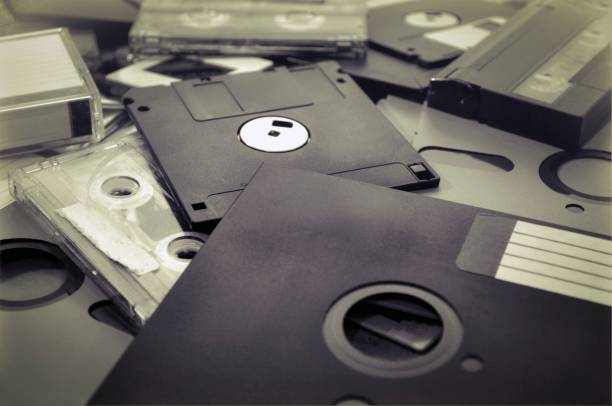

In [13]:
image_path_8260 = valid_data.iloc[8260]['image_path']
PIL.Image.open(image_path_8260)

In [14]:
from sklearn.model_selection import train_test_split

# 80% train, 20% validation
train_data, val_data = train_test_split(valid_data, test_size=0.2, stratify=data['label'], random_state=42)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")


Training samples: 6694
Validation samples: 1674


In [15]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(data['label'])

# Add encoded labels
train_data['label_encoded'] = label_encoder.transform(train_data['label'])
val_data['label_encoded'] = label_encoder.transform(val_data['label'])

# Label mapping
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label map:", label_map)


Label map: {'batteries': np.int64(0), 'clothes': np.int64(1), 'e-waste': np.int64(2), 'glass': np.int64(3), 'light blubs': np.int64(4), 'metal': np.int64(5), 'organic': np.int64(6), 'paper': np.int64(7), 'plastic': np.int64(8)}


#### Preparing dataset  for training


In [24]:
import tensorflow as tf


IMG_SIZE = 224
BATCH_SIZE = 32

def process_image(image_path, label):
    image = tf.io.read_file(image_path)
    # image = tf.image.decode_jpeg(image, channels=3)
    # image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # image = tf.cast(image, tf.float32) / 255.0
    # return image, label

    ext = tf.strings.lower(tf.strings.split(image_path, ".")[-1])

    def decode_jpeg(): return tf.image.decode_jpeg(image, channels=3)
    def decode_png(): return tf.image.decode_png(image, channels=3)


    image = tf.case(
        [(tf.equal(ext, "png"), decode_png)],
        default=decode_jpeg
    )

    # Explicitly set shape so tf.image.resize works
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


def make_dataset(data):
    paths = data['image_path'].values
    labels = data['label_encoded'].values
    new_data = tf.data.Dataset.from_tensor_slices((paths, labels))
    new_data = new_data.map(lambda x, y: process_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    new_data = new_data.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return new_data

train_new_data = make_dataset(train_data)
val_new_data = make_dataset(val_data)


#### Training with MobileNetV2

In [25]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

NUM_CLASSES = len(label_encoder.classes_)

# Load base MobileNetV2 model without top classification layer
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze base model

# Build your model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [26]:
EPOCHS = 5

history = model.fit(
    train_new_data,
    validation_data=val_new_data,
    epochs=EPOCHS
)


Epoch 1/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.5229 - loss: 1.4276 - val_accuracy: 0.7724 - val_loss: 0.6934
Epoch 2/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.7722 - loss: 0.6954 - val_accuracy: 0.8011 - val_loss: 0.6243
Epoch 3/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.8227 - loss: 0.5476 - val_accuracy: 0.8088 - val_loss: 0.5797
Epoch 4/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 451s 2s/step - accuracy: 0.8568 - loss: 0.4352 - val_accuracy: 0.8220 - val_loss: 0.5576
Epoch 5/5
210/210 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.8750 - loss: 0.3919 - val_accuracy: 0.8244 - val_loss: 0.5619


In [27]:
model.save("/content/drive/MyDrive/amdari/waste_classifier_mobilenetv2_v1.h5")


In [29]:
model.evaluate(val_new_data)


53/53 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8189 - loss: 0.5799


[0.5618818998336792, 0.8243727684020996]

#### Continued training to get better performance(% more epochs)


In [30]:
base_model.trainable = True


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [31]:
fine_tune_epochs = 5
total_epochs = 5 + fine_tune_epochs  # base + fine-tune

history_finetune = model.fit(
    train_new_data,
    validation_data=val_new_data,
    epochs=total_epochs,
    initial_epoch=5  # continue from where you left off
)


Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1625s 7s/step - accuracy: 0.6600 - loss: 1.0322 - val_accuracy: 0.8160 - val_loss: 0.6004
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1606s 8s/step - accuracy: 0.7983 - loss: 0.5948 - val_accuracy: 0.8136 - val_loss: 0.6085
Epoch 8/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1661s 8s/step - accuracy: 0.8423 - loss: 0.4763 - val_accuracy: 0.8160 - val_loss: 0.5856
Epoch 9/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1650s 8s/step - accuracy: 0.8598 - loss: 0.4141 - val_accuracy: 0.8256 - val_loss: 0.5519
Epoch 10/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1698s 8s/step - accuracy: 0.8897 - loss: 0.3507 - val_accuracy: 0.8369 - val_loss: 0.5304


In [34]:
model.save("/content/drive/MyDrive/amdari/finetuned_waste_classifier_mobilenetv2_v1.keras")

##### Getting Prediction Metrics(Optional)

In [32]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
class_names = ['batteries', 'clothes', 'e-waste', 'glass', 'light bulbs',
               'metal', 'organic', 'paper', 'plastic']


y_true = []
y_pred = []

for images, labels in val_new_data:
    probs = model.predict(images)
    preds = np.argmax(probs, axis=1)

    y_pred.extend(preds)
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [39]:

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

print("Confusion Matrix:\n")
print(cm_df)

Classification Report:

              precision    recall  f1-score   support

   batteries       0.79      0.90      0.84       225
     clothes       0.89      0.90      0.89       146
     e-waste       0.83      0.80      0.82       125
       glass       0.90      0.78      0.84       154
 light bulbs       0.91      0.85      0.88       130
       metal       0.76      0.81      0.79       218
     organic       0.84      0.80      0.82       134
       paper       0.92      0.85      0.89       294
     plastic       0.77      0.81      0.79       248

    accuracy                           0.84      1674
   macro avg       0.85      0.83      0.84      1674
weighted avg       0.84      0.84      0.84      1674

Confusion Matrix:

             batteries  clothes  e-waste  glass  light bulbs  metal  organic  \
batteries          203        0        6      1            1      6        1   
clothes              1      131        1      1            0      3        2   
e-waste     

##### REAL TIME DETECTION

In [2]:
# pip install gradio opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.7 MB/s eta 0:00:00


In [14]:
import gradio as gr
import numpy as np
import cv2
from keras.models import load_model

In [15]:
model = load_model("/content/drive/MyDrive/amdari/finetuned_waste_classifier_mobilenetv2_v1.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 162 variables whereas the saved optimizer has 322 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [18]:
class_names = ['batteries', 'clothes', 'e-waste', 'glass', 'light bulbs',
               'metal', 'organic', 'paper', 'plastic']

IMG_SIZE = 224

def classify_image(img):
    # Resize and normalize image
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    # Predict
    preds = model.predict(img)
    class_idx = np.argmax(preds)
    confidence = float(np.max(preds))

    label = class_names[class_idx]
    return {label: confidence}

In [20]:
# Gradio Interface
interface = gr.Interface(
    fn=classify_image,
    inputs=[
        gr.Image(label="Upload Waste Image or Use Webcam", image_mode='RGB')
    ],
    outputs=gr.Label(num_top_classes=3, label="Prediction"),
    live=True,
    title="Smart Waste Classifier",
    description="Upload an image or use your webcam to classify recyclable materials (e.g., plastic, paper, glass). Model: fine-tuned MobileNetV2.",
)

# Launch the app
interface.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://31c442f1d0bcb6c4bf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://31c442f1d0bcb6c4bf.gradio.live
